In [1]:
import os
import yaml
import glob
import pickle

from python_scripts.simulation import step_simulation
from python_scripts.visualizer import Visualizer
from commonroad.common.file_reader import CommonRoadFileReader

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [2]:
def merge_config(global_config, scenario_config):
    global_config["simulation_duration"]                    = scenario_config["simulation_duration"]
    global_config["initial_state_x"]                        = scenario_config["initial_state_x"]
    global_config["initial_state_y"]                        = scenario_config["initial_state_y"]
    global_config["initial_state_orientation"]              = scenario_config["initial_state_orientation"]
    global_config["initial_state_velocity"]                 = scenario_config["initial_state_velocity"]
    global_config["vehicle_type"]                           = scenario_config["vehicle_type"]
    global_config["vehicle_length"]                         = scenario_config["vehicle_length"]
    global_config["vehicle_width"]                          = scenario_config["vehicle_width"]
    global_config["reference_speed"]                        = scenario_config["reference_velocity"]
    global_config["planning_horizon"]                       = scenario_config["planning_horizon"]
    global_config["goal_point_x"]                           = scenario_config["goal_point_x"]
    global_config["goal_point_y"]                           = scenario_config["goal_point_y"]
    global_config["occlusion_params"]["vmax"]               = scenario_config["vmax"]
    global_config["occlusion_params"]["prediction_horizon"] = scenario_config["planning_horizon"]

    return global_config

def save_results(file_path, tracked_results, untracked_results, scenario_config):
    data = {
        "novel_method"      : {"ego_vehicle"        : tracked_results[0],
                               "scenarios"          : tracked_results[1],
                               "views"              : tracked_results[2],
                               "shadows"            : tracked_results[3],
                               "emergency_brakes"   : tracked_results[4],
                               "computational_time" : {"update_step"    : tracked_results[5][0],
                                                       "prediction_step": tracked_results[5][1]}},
        "baseline_method"  : {"ego_vehicle"        : untracked_results[0],
                              "scenarios"          : untracked_results[1],
                              "views"              : untracked_results[2],
                              "shadows"            : untracked_results[3],
                              "emergency_brakes"   : untracked_results[4],
                              "computational_time" : {"update_step"    : untracked_results[5][0],
                                                       "prediction_step": untracked_results[5][1]}},
        "vehicle_type"      : scenario_config["vehicle_type"], 
        "ego_speed"         : scenario_config["reference_velocity"],
        "other_speed"       : scenario_config["other_velocity"],
        "legal_merge"       : scenario_config["legal_merge"],
        "merge_ttc"         : scenario_config["merge_ttc"],
        "merge_dhw"         : scenario_config["merge_dhw"]
    }
    file = open(file_path, 'wb')
    pickle.dump(data, file)
    file.close()

def load_results(file_path):
    file = open(file_path, 'rb')
    data = pickle.load(file)
    file.close()
    
    return data

def plot_raw_scenario(timestep, scenario, config):
    plt.cla()
    Visualizer().plot_unsimulated(scenario, config, timestep)
    plt.axis('scaled')
    plt.xlim(0,420)
    plt.ylim(-45,-15)

## Visualise scenario

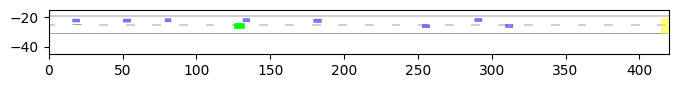

In [3]:
scenario_path = "scenarios/highd_loc1/ZAM_HighD-1_1_T-1"

#======================================================#
with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)
with open(scenario_path + ".yaml") as file:
    scenario_config = yaml.load(file, Loader=yaml.FullLoader)
config = merge_config(global_config, scenario_config)

scenario, _ = CommonRoadFileReader(scenario_path + ".xml").open()

fig = plt.figure(figsize=(12, 4))
anim = animation.FuncAnimation(fig, plot_raw_scenario, fargs=[scenario, config], frames=range(config["simulation_duration"]), interval=200, blit=False)
HTML(anim.to_html5_video())


## Run a single scenario

In [3]:
scenario_path = "scenarios/highd_loc1/ZAM_HighD-1_1_T-1"
results_folder = "results/"

#======================================================#
with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)
with open(scenario_path + ".yaml") as file:
    scenario_config = yaml.load(file, Loader=yaml.FullLoader)
config = merge_config(global_config, scenario_config)

scenario1, _ = CommonRoadFileReader(scenario_path + ".xml").open()
scenario2, _ = CommonRoadFileReader(scenario_path + ".xml").open()

config['occlusion_params']['velocity_tracking_enabled'] = True
tracked_results = step_simulation(scenario1, config)

config['occlusion_params']['velocity_tracking_enabled'] = False
untracked_results = step_simulation(scenario2, config)

save_path = os.path.join(results_folder, str(scenario1.scenario_id))
save_results(save_path, tracked_results, untracked_results, scenario_config)

Running simulation: 100%|██████████| 31/31 [00:19<00:00,  1.62it/s]


## Run all scenarios

ZAM_HighD-1_10_T-1


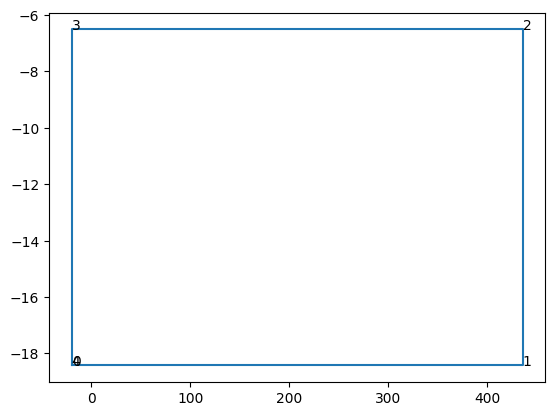

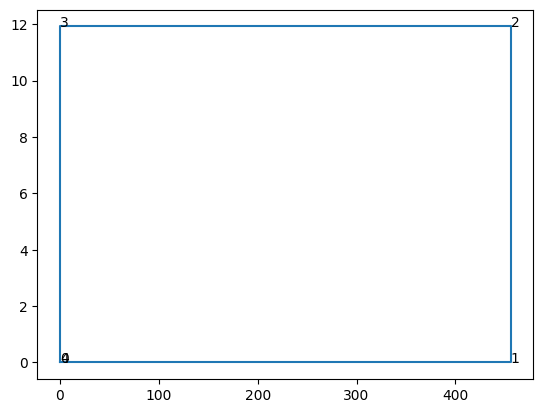

Running simulation:   0%|          | 0/31 [00:00<?, ?it/s]

Simulation raised an error for scenario  ZAM_HighD-1_10_T-1


TypeError: save_results() missing 7 required positional arguments: 'filename', 'tracked_vehicle', 'tracked_scenarios', 'tracked_shadows', 'baseline_vehicle', 'baseline_scenarios', and 'baseline_shadows'

In [ ]:
skip_existing = True            # Skips any scenarios that already have existing results.
scenario_path = "scenarios/"
results_path = "results/"

#=======================================================================================#
path_xml = os.path.join(scenario_path, "highd_loc*","*.xml")
path_yaml = os.path.join(scenario_path, "highd_loc*","*.yaml")

xml_list = sorted(glob.glob(path_xml))
yaml_list = sorted(glob.glob(path_yaml))

with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)

for xml_file, yaml_file in zip(xml_list, yaml_list):
    scenario1, _ = CommonRoadFileReader(xml_file).open()
    scenario2, _ = CommonRoadFileReader(xml_file).open()
    with open(yaml_file) as file:
        scenario_config = yaml.load(file, Loader=yaml.FullLoader)
    config = merge_config(global_config, scenario_config)

    if skip_existing and os.path.isfile(os.path.join(results_path, scenario1.scenario_id)):
        continue

    try:
        config['occlusion_params']['velocity_tracking_enabled'] = True
        tracked_results = step_simulation(scenario1, config)

        config['occlusion_params']['velocity_tracking_enabled'] = False
        untracked_results = step_simulation(scenario2, config)

    except Exception as e:
        print("Simulation raised an error for scenario ", scenario1.scenario_id)

    save_path = os.path.join(results_path, str(scenario1.scenario_id))
    save_results(save_path, tracked_results, untracked_results, scenario_config)

## Visualise single result

In [4]:
results_file = "results/ZAM_HighD-1_1_T-1"

#========================================#
data = load_results(results_file)
print(tracked_results[5])
print("Update time novel method: ", data["novel_method"]["computational_time"]["update_step"])
print("Prediction time novel method: ", data["novel_method"]["computational_time"]["prediction_step"])
print("Update time baseline method: ", data["baseline_method"]["computational_time"]["update_step"])
print("Prediction time novel method: ", data["baseline_method"]["computational_time"]["prediction_step"])

(0.34226099383870967, 0.6394991910645162)
Update time novel method:  0.34226099383870967
Prediction time novel method:  0.6394991910645162
Update time baseline method:  0.12696038941935484
Prediction time novel method:  0.4396812843225805


## Visualise all results

In [ ]:
results_folder = "results/"

#=========================#